# 라이브러리 및 데이터 로드

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression #로지스틱 회귀
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트
import tensorflow as tf
from tensorflow.keras import layers
from catboost import Pool,CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 100
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [6]:
# 인덱스 설정
tmp_train=pd.read_csv("train.csv").set_index(keys='id')
tmp_test=pd.read_csv("test.csv").set_index(keys='id')
d_code=pd.read_csv("속성_D_코드.csv").set_index(keys='속성 D 코드')
h_code=pd.read_csv("속성_H_코드.csv").set_index(keys='속성 H 코드')
l_code=pd.read_csv("속성_L_코드.csv").set_index(keys='속성 L 코드')


# EDA

In [7]:
tmp_train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,True,True,True,False,False,False,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,False,False,False,True,True,False,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,False,False,False,True,False,False,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,False,False,False,True,False,False,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,True,True,True,False,False,False,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,False,False,False,True,False,False,1,1,2,2,1192,935,1228,3,1,1,59,4,95,3,3,5,1,1,2,354,147,1,5,65,503156,285850,2020-03-13 12:55:52,1
501947,True,True,False,True,False,False,1,6,2,1,118,113,110,4,1,1,105,142,95,3,3,10,2,1,2,163,120,1,4,142,676255,456996,2020-01-20 11:51:51,1
501948,True,True,True,True,False,False,1,7,4,1,147,46,145,4,1,1,59,127,139,3,1,5,1,1,2,438,147,2,7,65,484528,293258,2020-08-05 17:27:24,1


In [8]:
len(tmp_train[tmp_train['target']==1])

250845

target 값은 0, 1 균등히 분포

In [11]:
# 사용자 번호
print(len(tmp_train['person_rn'].unique()))
# 50만개 중 30만개의 사용자 번호

# 컨텐츠번호
len(tmp_train['contents_rn'].unique())
# 50만개 중 약 28만개의 다른 컨텐츠가 있음



300177


283359

--> 생각보다 같은 사용자와 컨텐츠가 많음을 의미 

In [12]:
print(tmp_train['person_prefer_f'].unique())
print(tmp_train['person_prefer_g'].unique())


[1]
[1]


-------------------> 전처리 단계에서 삭제시켜도 될 컬럼들

아래부터는
회원 선호 속성 a와 a의 하위 속성을 3등분으로 만들어서 컨텐츠 a의 속성과 매칭을 시키기 위해 시각화를 해서 파악

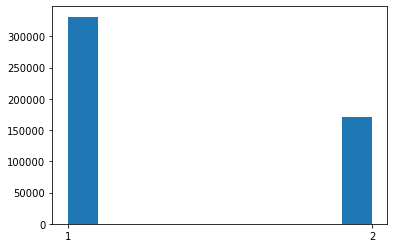

142560

In [13]:
plt.xticks([1, 2])
plt.hist(tmp_train['person_attribute_a'])
plt.show()

len(tmp_train[tmp_train['person_attribute_a'] == 1])
len(tmp_train[tmp_train['person_attribute_a'] == 2])

len(tmp_train.loc[(tmp_train['person_attribute_a_1'] == 0) | (tmp_train['person_attribute_a_1'] == 1) ])
len(tmp_train.loc[(tmp_train['person_attribute_a_1'] == 3) | (tmp_train['person_attribute_a_1'] == 4) | (tmp_train['person_attribute_a_1'] == 2)])

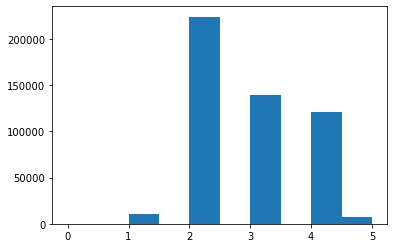

In [14]:
plt.xticks([0,1,2,3,4,5])
plt.hist(tmp_train['person_attribute_b'])
plt.show()


a의 '1'이 '2'의 약 두배의 크기를 가짐

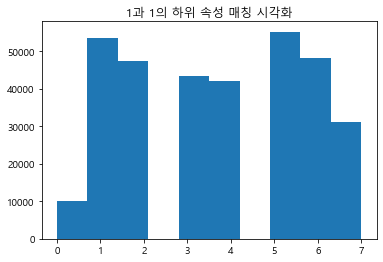

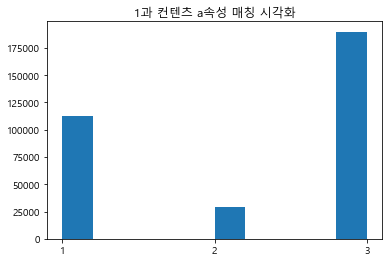

In [15]:
plt.rcParams['font.family'] = 'Malgun Gothic'
# '1'과 '1'의 하위 속성 매칭 시각화
data_a1 = tmp_train['person_attribute_a_1'][tmp_train['person_attribute_a'] == 1]
plt.xticks(np.arange(8))
plt.hist(data_a1)
plt.title('1과 1의 하위 속성 매칭 시각화')
plt.show()


# '1'과 컨텐츠 a속성 매칭 시각화
condata_a1 = tmp_train['contents_attribute_a'][tmp_train['person_attribute_a'] == 1]
plt.xticks([1, 2, 3])
plt.hist(condata_a1)
plt.title('1과 컨텐츠 a속성 매칭 시각화')
plt.show()

# 1은 2와 달리 0이 젤 낮고, 나머지 비슷
# 1은 컨텐츠 선호의 1, 3을 2에비해 좋아함 

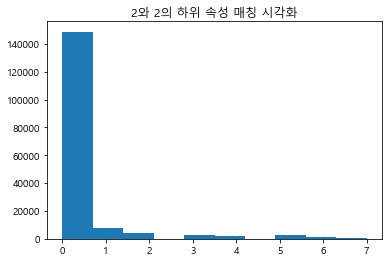

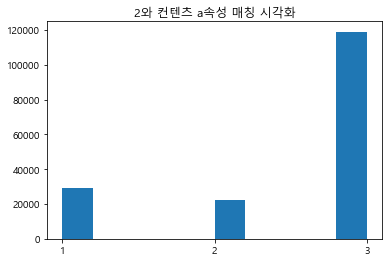

(148678,)


(170691,)

In [16]:
# '2'과 '2'의 하위 속성 매칭 시각화
data_a2 = tmp_train['person_attribute_a_1'][tmp_train['person_attribute_a'] == 2]
plt.xticks(np.arange(8))
plt.hist(data_a2)
plt.title('2와 2의 하위 속성 매칭 시각화')
plt.show()

# '2'와 컨텐츠 a속성 매칭 시각화
condata_a1 = tmp_train['contents_attribute_a'][tmp_train['person_attribute_a'] == 2]
plt.xticks([1, 2, 3])
plt.hist(condata_a1)
plt.title('2와 컨텐츠 a속성 매칭 시각화')
plt.show()

condata__a1 = tmp_train['contents_attribute_a']
condition = (tmp_train['person_attribute_a'] == 2) & (tmp_train['person_attribute_a_1'] == 0)
k = tmp_train['contents_attribute_a'][condition]

print(k.shape)
data_a2.shape

# 2는 0이 존나많음
# 컨텐츠 속성의 3을 존나 좋아함

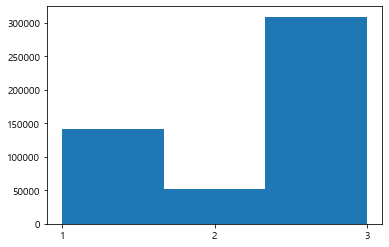

In [17]:
# 컨텐츠 속성 a
plt.xticks([1, 2, 3])
plt.hist(tmp_train['contents_attribute_a'], bins = 3)
plt.show()


## 시간대 별로 나눈 컬럼

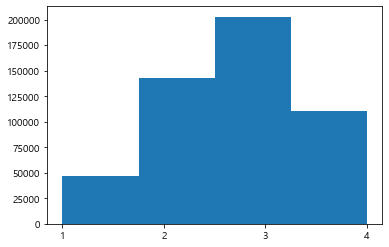

In [18]:
tmp_train['Quarter_Day'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 1 if 0 <= x <= 6 else(2 if 6<x<=12 else(3 if 12<x<=18 else 4))).astype('int64')
#tmp_train['second_time'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 2 if 6 < x <= 12).astype('int64')
#tmp_train['third_time'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 12 < x <= 18).astype('int64')
#tmp_train['last_time'] = tmp_train['contents_open_dt'].astype('datetime64').dt.hour.map(lambda x: 18 < x <= 24).astype('int64')
#tmp_train['first_time'].head(100)
plt.xticks([1,2,3,4])
plt.hist(tmp_train['Quarter_Day'],bins=4)
plt.show()
#  1. 개수 파악
#  2. EDA 필요

# 시간대, 요일 과 target 간 연관성

C:\Users\wnrrh\AppData\Local\Temp/ipykernel_24496/1870349465.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=np.array([[len(tmp_train[tmp_train['Quarter_Day']==i][tmp_train['target']==j]) for i in range(1,5)] for j in range(2)])


([<matplotlib.axis.XTick at 0x21d9e2798b0>,
 [Text(0, 0, 'target_0'), Text(1, 0, 'target_1')])

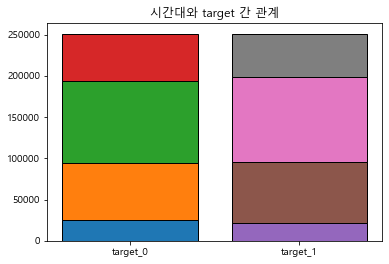

In [19]:
data=np.array([[len(tmp_train[tmp_train['Quarter_Day']==i][tmp_train['target']==j]) for i in range(1,5)] for j in range(2)])
idx=np.array([0,1])
plt.title('시간대와 target 간 관계')
for j in range(2):
    for i in range(4):
        plt.bar(np.array([j]),data[j][i],bottom=np.sum(data[j][:i],axis=0),edgecolor='black')
plt.xticks(idx,['target_0','target_1'])


In [20]:
tmp_train.drop(['Quarter_Day'],axis=1,inplace=True)

In [21]:
tmp_tmp=tmp_train.copy()
tmp_tmp['contents_open_dt']=tmp_tmp['contents_open_dt'].astype('datetime64[ns]').dt.dayofweek

C:\Users\wnrrh\AppData\Local\Temp/ipykernel_24496/34686349.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=np.array([[len(tmp_tmp[tmp_tmp['contents_open_dt']==i][tmp_tmp['target']==j]) for i in range(7)] for j in range(2)])


([<matplotlib.axis.XTick at 0x21d9e463ca0>,
 [Text(0, 0, 'target_0'), Text(1, 0, 'target_1')])

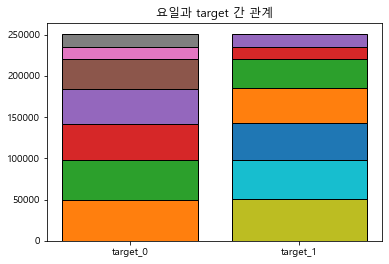

In [22]:

data=np.array([[len(tmp_tmp[tmp_tmp['contents_open_dt']==i][tmp_tmp['target']==j]) for i in range(7)] for j in range(2)])
idx=np.arange(2)
plt.bar(idx,0)
plt.title('요일과 target 간 관계')
for j in range(2):
    for i in range(7):
        plt.bar(np.array([j]),data[j][i],bottom=np.sum(data[j][:i],axis=0),edgecolor='black')
plt.xticks(idx,['target_0','target_1'])

# 결측치 처리

In [23]:
tmp_train.isna().sum()

d_l_match_yn              0
d_m_match_yn              0
d_s_match_yn              0
h_l_match_yn              0
h_m_match_yn              0
h_s_match_yn              0
person_attribute_a        0
person_attribute_a_1      0
person_attribute_b        0
person_prefer_c           0
person_prefer_d_1         0
person_prefer_d_2         0
person_prefer_d_3         0
person_prefer_e           0
person_prefer_f           0
person_prefer_g           0
person_prefer_h_1         0
person_prefer_h_2         0
person_prefer_h_3         0
contents_attribute_i      0
contents_attribute_a      0
contents_attribute_j_1    0
contents_attribute_j      0
contents_attribute_c      0
contents_attribute_k      0
contents_attribute_l      0
contents_attribute_d      0
contents_attribute_m      0
contents_attribute_e      0
contents_attribute_h      0
person_rn                 0
contents_rn               0
contents_open_dt          0
target                    0
dtype: int64

 train dataset에 결측치 없음 확인

In [24]:
tmp_test.isna().sum()

d_l_match_yn              0
d_m_match_yn              0
d_s_match_yn              0
h_l_match_yn              0
h_m_match_yn              0
h_s_match_yn              0
person_attribute_a        0
person_attribute_a_1      0
person_attribute_b        0
person_prefer_c           0
person_prefer_d_1         0
person_prefer_d_2         0
person_prefer_d_3         0
person_prefer_e           0
person_prefer_f           0
person_prefer_g           0
person_prefer_h_1         0
person_prefer_h_2         0
person_prefer_h_3         0
contents_attribute_i      0
contents_attribute_a      0
contents_attribute_j_1    0
contents_attribute_j      0
contents_attribute_c      0
contents_attribute_k      0
contents_attribute_l      0
contents_attribute_d      0
contents_attribute_m      0
contents_attribute_e      0
contents_attribute_h      0
person_rn                 0
contents_rn               0
contents_open_dt          0
dtype: int64

 test dataset에 결측치 없음을 확인

# DataFrame 전처리 - 회원과 컨텐츠 속성 매칭
처리 전 copy해놓기

## DF 전처리

In [25]:
def createDF(main_df,d_code=d_code,h_code=h_code,l_code=l_code): #n:세분류,s:소분류,m:중분류,l:대분류
    main_df=main_df.copy()
#     df 복사본 만들기

    
    
    main_df["person_prefer_d_1_n"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df["person_prefer_d_1_s"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df["person_prefer_d_1_m"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df["person_prefer_d_1_l"]=main_df["person_prefer_d_1"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    main_df["person_prefer_d_2_n"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df["person_prefer_d_2_s"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df["person_prefer_d_2_m"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df["person_prefer_d_2_l"]=main_df["person_prefer_d_2"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    main_df["person_prefer_d_3_n"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df["person_prefer_d_3_s"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df["person_prefer_d_3_m"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df["person_prefer_d_3_l"]=main_df["person_prefer_d_3"].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])
    
    main_df['person_prefer_h_1_m']=main_df['person_prefer_h_1'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['person_prefer_h_1_l']=main_df['person_prefer_h_1'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    main_df['person_prefer_h_2_m']=main_df['person_prefer_h_2'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['person_prefer_h_2_l']=main_df['person_prefer_h_2'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    main_df['person_prefer_h_3_m']=main_df['person_prefer_h_3'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['person_prefer_h_3_l']=main_df['person_prefer_h_3'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    main_df['contents_attribute_l_n']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 세분류코드"])
    main_df['contents_attribute_l_s']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 소분류코드"])
    main_df['contents_attribute_l_m']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 중분류코드"])
    main_df['contents_attribute_l_l']=main_df['contents_attribute_l'].apply(lambda x: l_code.loc[x,"속성 L 대분류코드"])
    
    main_df['contents_attribute_d_n']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 세분류코드"])
    main_df['contents_attribute_d_s']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 소분류코드"])
    main_df['contents_attribute_d_m']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 중분류코드"])
    main_df['contents_attribute_d_l']=main_df['contents_attribute_d'].apply(lambda x: d_code.loc[x,"속성 D 대분류코드"])

    main_df['contents_attribute_h_m']=main_df['contents_attribute_h'].apply(lambda x: h_code.loc[x,"속성 H 중분류코드"])
    main_df['contents_attribute_h_l']=main_df['contents_attribute_h'].apply(lambda x: h_code.loc[x,"속성 H 대분류코드"])
    
    return main_df
    

## DF 회원과 컨텐츠 속성 매칭 전처리

In [26]:
def preprocessing(df:pd.DataFrame)->pd.DataFrame:
#     '->'는 Return 값이 어떤 상태인지를 명시하기 위함
    
#     회원 속성과 컨텐츠속성 매칭해서 True, False 명시
    print('--------start---------')
    df=df.copy()
#     df 복사본 만들기
    df.drop(['person_prefer_f','person_prefer_g','contents_rn','person_rn'],axis=1,inplace=True)
#    person_prefer_f,g는 값이 모두 1임
    
    
    
    print('---------mid_1----------')
    df['d_match_yn']=df['d_s_match_yn'] #d코드 매칭여부
    df['d_n_match_yn']=df['d_m_match_yn'] #d 세분류 매칭여부
    df['d_s_match_yn']=(df['person_prefer_d_1_s']==df['contents_attribute_d_s']) #d 소분류 매칭여부
    df['d_m_matck_yn']=(df['person_prefer_d_1_m']==df['contents_attribute_d_m']) #d 중분류 매칭여부
    
    df['d_2_match_yn']=(df['person_prefer_d_2']==df['contents_attribute_d'])
    df['d_2_n_match_yn']=(df['person_prefer_d_2_n']==df['contents_attribute_d_n'])
    df['d_2_s_match_yn']=(df['person_prefer_d_2_s']==df['contents_attribute_d_s'])
    df['d_2_m_match_yn']=(df['person_prefer_d_2_m']==df['contents_attribute_d_m'])
    df['d_2_l_match_yn']=(df['person_prefer_d_2_l']==df['contents_attribute_d_l'])
    
    df['d_3_match_yn']=(df['person_prefer_d_3']==df['contents_attribute_d'])
    df['d_3_n_match_yn']=(df['person_prefer_d_3_n']==df['contents_attribute_d_n'])
    df['d_3_s_match_yn']=(df['person_prefer_d_3_s']==df['contents_attribute_d_s'])
    df['d_3_m_match_yn']=(df['person_prefer_d_3_m']==df['contents_attribute_d_m'])
    df['d_3_l_match_yn']=(df['person_prefer_d_3_l']==df['contents_attribute_d_l'])
    
    df['h_match_yn']=df['h_s_match_yn']
    
    df['h_2_match_yn']=(df['person_prefer_h_2']==df['contents_attribute_h'])
    df['h_2_m_match_yn']=(df['person_prefer_h_2_m']==df['contents_attribute_h_m'])
    df['h_2_l_match_yn']=(df['person_prefer_h_2_l']==df['contents_attribute_h_l'])
    
    df['h_3_match_yn']=(df['person_prefer_h_3']==df['contents_attribute_h'])
    df['h_3_m_match_yn']=(df['person_prefer_h_3_m']==df['contents_attribute_h_m'])
    df['h_3_l_match_yn']=(df['person_prefer_h_3_l']==df['contents_attribute_h_l'])
    
    df['a_match_yn']=(df['person_attribute_a']==df['contents_attribute_a'])
    df['c_match_yn']=(df['person_prefer_c']==df['contents_attribute_c'])
    df['e_match_yn']=(df['person_prefer_e']==df['contents_attribute_e'])
    
    print('---------mid_2----------')
    
    for column in df.keys():
        if column=='contents_open_dt':
            df[column]=df[column].astype('datetime64').dt.dayofweek #0~6(0부터 월요일~)
#             dt.dayofweek 에서 dt는 접근자
        if df[column].dtypes!='datetime64':
            df[column]=df[column].astype('int64')

    print('---------mid_3----------')
    
    df['contents_attribute_k']-=1
    df.drop(['h_s_match_yn','contents_open_dt'],axis=1,inplace=True)
    print("-----------finish------------")
    
    return df


## New DF 생성하고 전처리 한 DF 지정(train, test)

In [27]:
train_set=preprocessing(createDF(tmp_train))
test_set=preprocessing(createDF(tmp_test))

--------start---------
---------mid_1----------
---------mid_2----------
---------mid_3----------
-----------finish------------
--------start---------
---------mid_1----------
---------mid_2----------
---------mid_3----------
-----------finish------------


## Train, Test set Columns

In [28]:
train_set.keys()

Index(['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'person_attribute_a', 'person_attribute_a_1',
       'person_attribute_b', 'person_prefer_c', 'person_prefer_d_1',
       'person_prefer_d_2', 'person_prefer_d_3', 'person_prefer_e',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'target', 'person_prefer_d_1_n',
       'person_prefer_d_1_s', 'person_prefer_d_1_m', 'person_prefer_d_1_l',
       'person_prefer_d_2_n', 'person_prefer_d_2_s', 'person_prefer_d_2_m',
       'person_prefer_d_2_l', 'person_prefer_d_3_n', 'person_prefer_d_3_s',
       'person_prefer_d_3_m', 'person_prefer_d_3_l', 'person_prefer_h_1_m',
       'person_

In [29]:
test_set.keys()

Index(['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'person_attribute_a', 'person_attribute_a_1',
       'person_attribute_b', 'person_prefer_c', 'person_prefer_d_1',
       'person_prefer_d_2', 'person_prefer_d_3', 'person_prefer_e',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_prefer_d_1_n', 'person_prefer_d_1_s',
       'person_prefer_d_1_m', 'person_prefer_d_1_l', 'person_prefer_d_2_n',
       'person_prefer_d_2_s', 'person_prefer_d_2_m', 'person_prefer_d_2_l',
       'person_prefer_d_3_n', 'person_prefer_d_3_s', 'person_prefer_d_3_m',
       'person_prefer_d_3_l', 'person_prefer_h_1_m', 'person_prefer_h_1_l',
  

## Data Split

In [30]:
# Column 설정
key_list=list(train_set.keys())
target_idx=key_list.index('target')
# train, test Split
y_train=train_set['target']
x_train=train_set[key_list[:target_idx]+key_list[target_idx+1:]]

In [31]:
y_train

id
0         1
1         0
2         0
3         0
4         0
         ..
501946    1
501947    1
501948    1
501949    1
501950    1
Name: target, Length: 501951, dtype: int64

In [32]:
x_train

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_1,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_prefer_d_1_n,person_prefer_d_1_s,person_prefer_d_1_m,person_prefer_d_1_l,person_prefer_d_2_n,person_prefer_d_2_s,person_prefer_d_2_m,person_prefer_d_2_l,person_prefer_d_3_n,person_prefer_d_3_s,person_prefer_d_3_m,person_prefer_d_3_l,person_prefer_h_1_m,person_prefer_h_1_l,person_prefer_h_2_m,person_prefer_h_2_l,person_prefer_h_3_m,person_prefer_h_3_l,contents_attribute_l_n,contents_attribute_l_s,contents_attribute_l_m,contents_attribute_l_l,contents_attribute_d_n,contents_attribute_d_s,contents_attribute_d_m,contents_attribute_d_l,contents_attribute_h_m,contents_attribute_h_l,d_match_yn,d_n_match_yn,d_m_matck_yn,d_2_match_yn,d_2_n_match_yn,d_2_s_match_yn,d_2_m_match_yn,d_2_l_match_yn,d_3_match_yn,d_3_n_match_yn,d_3_s_match_yn,d_3_m_match_yn,d_3_l_match_yn,h_match_yn,h_2_match_yn,h_2_m_match_yn,h_2_l_match_yn,h_3_match_yn,h_3_m_match_yn,h_3_l_match_yn,a_match_yn,c_match_yn,e_match_yn
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,1,4,3,5,275,370,369,8,4,95,59,3,3,10,2,1,1,1608,275,1,4,139,275,274,274,216,369,368,297,216,369,368,297,216,316,3,398,94,368,58,1607,1606,1605,2016,275,274,274,216,422,94,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,1,1,3,4,1,114,181,175,4,131,101,96,1,3,5,1,1,1,1608,275,1,4,133,114,109,56,1,175,152,56,1,175,152,56,1,417,94,400,94,399,94,1607,1606,1605,2016,275,274,274,216,417,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1
2,0,0,0,1,0,2,0,3,5,464,175,452,3,54,263,56,3,1,10,2,1,0,1600,94,1,4,53,464,463,450,377,175,152,56,1,452,451,450,377,364,48,528,250,366,48,1599,1595,1572,2016,92,91,56,1,363,48,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,2,0,2,5,703,705,704,3,72,227,2,1,3,5,1,1,1,1608,275,5,3,74,703,703,690,618,703,703,690,618,703,703,690,618,379,71,495,226,315,1,1607,1606,1605,2016,275,274,274,216,381,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,1,1,0,0,1,3,4,5,275,370,369,4,214,210,209,1,1,10,2,1,1,1608,275,1,4,74,275,274,274,216,369,368,297,216,369,368,297,216,483,208,481,208,480,208,1607,1606,1605,2016,275,274,274,216,381,71,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,0,0,0,1,0,1,1,2,2,1192,935,1228,3,59,4,95,3,3,5,1,1,1,354,147,1,5,65,1192,1180,1169,926,929,928,927,926,1227,1227,1227,926,368,58,316,3,398,94,352,347,346,2006,145,123,56,1,373,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
501947,1,1,1,1,0,1,6,2,1,118,113,110,4,105,142,95,3,3,10,2,1,1,163,120,1,4,142,114,109,56,1,110,109,56,1,110,109,56,1,401,94,425,94,398,94,155,138,99,2006,114,109,56,1,425,94,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,0,1,0,1,1
501948,1,1,1,1,0,1,7,4,1,147,46,145,4,59,127,139,3,1,5,1,1,1,438,147,2,7,65,145,123,56,1,46,43,2,1,145,123,56,1,368,58,413,94,422,94,437,417,407,2006,145,123,56,1,373,58,1,1,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0


# Optuna 파리미터 최적화

In [33]:
#op_x_train,op_x_val,op_y_train,op_y_val=train_test_split(x_train,y_train,test_size=0.2,shuffle=True,stratify=y_train,random_state=50)

In [34]:
def objective(trial):
    op_x_train,op_x_val,op_y_train,op_y_val=train_test_split(x_train,y_train,test_size=0.2,shuffle=True,stratify=y_train,random_state=50)
    op_cat_features=op_x_train.columns[x_train.nunique()>2].to_list()
    
    param={
        'random_state':50,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'objective':trial.suggest_categorical('objective',['Logloss','CrossEntropy']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "depth": trial.suggest_int("depth", 4, 16),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb"
    }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 50)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    gbm = CatBoostClassifier(**param,
                             eval_metric='F1',
                            )

    gbm.fit(op_x_train, op_y_train,
            eval_set=[(op_x_val, op_y_val)], 
            verbose=100, early_stopping_rounds=100,
           cat_features=op_cat_features)

    preds = gbm.predict(op_x_val)
    pred_labels = np.rint(preds)
    accuracy = f1_score(op_y_val, pred_labels)
    return accuracy
    

In [ ]:
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed=50))
study.optimize(objective, n_trials = 10)

[I 2022-10-22 01:26:46,629] A new study created in memory with name: no-name-40bb41a7-774b-4440-838a-c0e8bd2621ef


0:	learn: 0.5068926	test: 0.5011599	best: 0.5011599 (0)	total: 3.55s	remaining: 59m 2s
100:	learn: 0.6096258	test: 0.6088979	best: 0.6101827 (83)	total: 6m 19s	remaining: 56m 17s
200:	learn: 0.6198556	test: 0.6152379	best: 0.6156455 (193)	total: 12m 18s	remaining: 48m 54s
300:	learn: 0.6263212	test: 0.6209928	best: 0.6209928 (300)	total: 18m 8s	remaining: 42m 8s
400:	learn: 0.6308056	test: 0.6251656	best: 0.6254227 (396)	total: 23m 37s	remaining: 35m 16s
500:	learn: 0.6342744	test: 0.6273920	best: 0.6274081 (499)	total: 28m 59s	remaining: 28m 52s
600:	learn: 0.6369283	test: 0.6293341	best: 0.6294481 (599)	total: 34m 15s	remaining: 22m 44s
700:	learn: 0.6387380	test: 0.6299766	best: 0.6302861 (654)	total: 39m 35s	remaining: 16m 53s
800:	learn: 0.6404734	test: 0.6311401	best: 0.6311401 (800)	total: 44m 54s	remaining: 11m 9s
900:	learn: 0.6425785	test: 0.6315130	best: 0.6315570 (899)	total: 50m 18s	remaining: 5m 31s
999:	learn: 0.6442658	test: 0.6323450	best: 0.6323450 (999)	total: 55m 47

[I 2022-10-22 02:22:46,637] Trial 0 finished with value: 0.632344987902652 and parameters: {'learning_rate': 0.053775765740477724, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.4566969187504992, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 17.327060228134865}. Best is trial 0 with value: 0.632344987902652.


0:	learn: 0.5700784	test: 0.5655548	best: 0.5655548 (0)	total: 4.49s	remaining: 1h 14m 43s
100:	learn: 0.6388815	test: 0.6124186	best: 0.6126908 (97)	total: 9m 40s	remaining: 1h 26m 11s


## 하이퍼파라미터 중요도 및 학습 과정

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

# Modeling - Catboost 

In [ ]:
#캣부스트(CatBoost)
cat_features = x_train.columns[x_train.nunique()>2].to_list()
is_holdout = False

cv = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = 50)

scores=[]
models=[]

for train_idx,val_idx in cv.split(x_train,y_train):
    print('='*60)
    preds=[]
    
    model = CatBoostClassifier(
        **study.best_params,
        #iterations=3000,
        #task_type='GPU',
        eval_metric='F1',
        #cat_features=cat_features,
        #one_hot_max_size=4
    )
    
    model.fit(x_train.iloc[train_idx],y_train[train_idx],
              eval_set=[(x_train.iloc[val_idx],y_train[val_idx])],
              early_stopping_rounds=100,
              cat_features=cat_features,
              verbose=100)
    
    models.append(model)
    scores.append(model.get_best_score()['validation']['F1'])
    if is_holdout:
        break

print(scores)
print(np.mean(scores))

## 최적 threshold 탐색

In [ ]:
N=61

# 0.0015*i 부터 threshold 파악

In [ ]:
thresholds=[0.3+i*0.005 for i in range(N)]
scores_2=[]
y_graph=[]

for threshold in thresholds:
    print(f'threshold:{threshold}')
    for i,(train_idx,val_idx) in enumerate(cv.split(x_train,y_train)):
        pred=models[i].predict_proba(x_train.iloc[val_idx])[:,1]
        pred=np.where(pred>=threshold,1,0)
        score=f1_score(y_train[val_idx],pred)
        scores_2.append(score)
    y_graph.append(scores_2)
    scores_2=[]
print(y_graph)

In [ ]:
df_y_graph=pd.DataFrame(y_graph)

In [ ]:
df_y_graph['threshold']=thresholds

In [ ]:
df_y_graph.set_index('threshold',inplace=True)

## 각 threshold 별, f1_score 파악

In [ ]:
df_y_graph

In [ ]:
df_graph=pd.DataFrame({'threshold':[],'model_num':[],'f1_score':[]})
df_graph

In [ ]:
for i in range(N):
    for j in range(5):
        df_graph=df_graph.append({'threshold':thresholds[i],'model_num':j,'f1_score':df_y_graph.loc[thresholds[i],j]},ignore_index=True)

In [ ]:
df_graph['model_num']=df_graph['model_num'].astype('int64')

In [ ]:
df_graph

## 각 threshold 별, 5회 실시한 f1_score 평균값 DataFrame으로 표현

In [ ]:
df_mean_graph=pd.DataFrame({'threshold':[],'f1_score':[]})

In [ ]:
for i in range(N):
    df_mean_graph=df_mean_graph.append({'threshold':thresholds[i],'f1_score':df_graph[df_graph['threshold']==thresholds[i]]['f1_score'].mean()},ignore_index=True)

In [ ]:
df_mean_graph

## Model Visulization & f1_score 높은 5개 값 threshold 파악

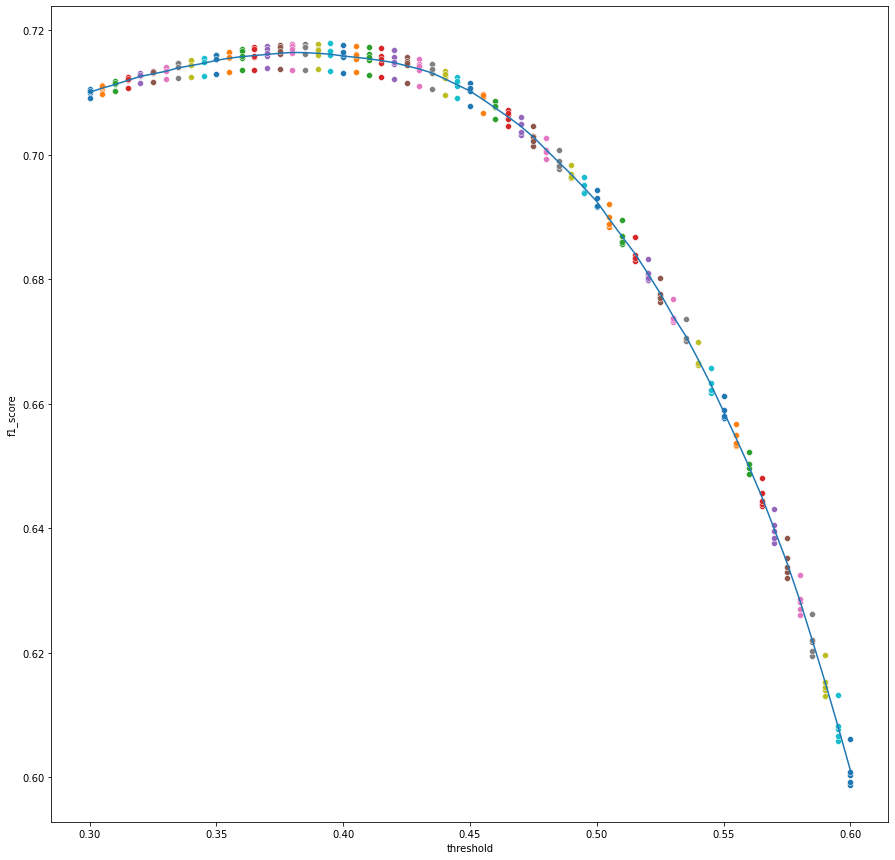

,threshold,f1_score
16,0.380,0.716475
17,0.385,0.716429
18,0.390,0.716331
15,0.375,0.716327
19,0.395,0.716183


In [141]:
plt.figure(figsize=(15,15))
x='threshold'
y='f1_score'
for i in range(N):
    sns.scatterplot(data=df_graph[df_graph['threshold']==thresholds[i]],x=x,y=y,ci=None)
sns.lineplot(data=df_mean_graph,x=x,y=y,ci=None)
plt.show()
pd.DataFrame(df_mean_graph).sort_values(by='f1_score',ascending=False).head(5)

## Model Save

In [168]:
for i in range(1,6):
    models[i-1].save_model(f'cat_boost_model_{i}')

## Model loading

In [169]:
l_models=[CatBoostClassifier().load_model(f'cat_boost_model_{i}') for i in range(1,6)]

## 최적 threshold를 이용하여 test set 예측

In [170]:
threshold=0.3475
pred_list=[]
scores_2=[]

for i,(train_idx,val_idx) in enumerate(cv.split(x_train,y_train)):
    pred=l_models[i].predict_proba(x_train.iloc[val_idx])[:,1]
    pred=np.where(pred>=threshold,1,0)
    score=f1_score(y_train[val_idx],pred)
    scores_2.append(score)
    pred=l_models[i].predict_proba(test_set)[:,1]
    pred_list.append(pred)

print(scores_2)
print(np.mean(scores_2))

[0.7151653151792561, 0.7129960824391074, 0.7158379929313318, 0.715831849500658, 0.7151491699880045]
0.7149960820076715


# Submission

## 산술평균 앙상블

In [171]:
#preds=model.predict(test_set) # catboost 말고

preds=np.mean(pred_list,axis=0) # catboost
preds=np.where(preds>=th
               reshold,1,0) # catboost


## 제출

In [172]:
submission=pd.read_csv('sample_submission.csv')
submission['target']=preds.round()
submission.to_csv('D:/Users/user/Desktop/submission.csv',index=False)